### 이미지 속 강아지 찾고, 각 강아지 종류 맞추기
#### MobileNet SSD  모델 사용

In [2]:
# pip install tensorflow opencv-python matplotlib

In [67]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from PIL import Image

from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions


### 강아지탐지를 위해 MobileNet SSD 모델 가져옴 

In [68]:
# MobileNet SSD 모델 로딩
prototxt = "deploy.prototxt"  # MobileNet SSD prototxt 파일 경로
caffe_model = "mobilenet_iter_73000.caffemodel"  # 모델 가중치 파일 경로
net = cv2.dnn.readNetFromCaffe(prototxt, caffe_model)


In [69]:
# 클래스 이름 (MobileNet SSD에서 감지 가능한 객체들)
class_names = ["background", "airplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", 
               "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", 
               "tvmonitor"]

(169, 298, 3)


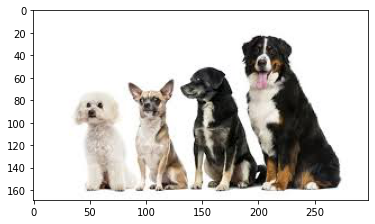

In [70]:
# 예측에 사용할 강아지 이미지 로드
img = Image.open('doggy.jpg')

# PIL 이미지를 NumPy 배열로 변환
img = np.array(img)

print(img.shape)
plt.imshow(img)
plt.show()

In [71]:
# 이미지 크기 조정
height, width = img.shape[:2]  # 이제 shape를 사용할 수 있습니다
blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 0.007843, (300, 300), 127.5, swapRB=True, crop=False)


In [72]:
# 네트워크에 blob을 입력
net.setInput(blob)
detections = net.forward()


In [73]:
# 객체 탐지 수행
detections = net.forward()

### 강아지 탐지 - 4마리 모두 가져올수 있을지???

In [74]:
# 강아지 탐지
for i in range(detections.shape[2]):
    confidence = detections[0, 0, i, 2]

    if confidence > 0.2:  # 신뢰도 임계값
        # 객체의 좌표
        box = detections[0, 0, i, 3:7] * np.array([width, height, width, height])
        (startX, startY, endX, endY) = box.astype("int")

        # 객체를 이미지에 그리기
        label = ""
        cv2.rectangle(img, (startX, startY), (endX, endY), (0, 255, 0), 2)
        cv2.putText(img, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)


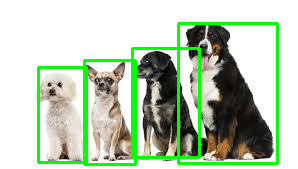

In [75]:
# 이미지 출력 (PIL 객체로 다시 변환하여 출력)
result_img = Image.fromarray(img)
result_img.show()

### 강아지 종류 예측 - InceptionV3 모델로 강아지 종류에 맞게 예측할수 있을까???
### 강아지 종류를 예측하는데 Reset60모델을 사용했을시 잘 예측이 안되서 InceptionV3모델 사용함

In [76]:
# 강아지 종류 예측을 위한 InceptionV3 모델 로드
model_incep = InceptionV3(weights='imagenet')

In [77]:
# 각 강아지 탐지된 영역에 대해 라벨 붙이기
for i in range(detections.shape[2]):
    confidence = detections[0, 0, i, 2]

    if confidence > 0.2:  # 신뢰도 임계값
        # 객체의 좌표
        box = detections[0, 0, i, 3:7] * np.array([width, height, width, height])
        (startX, startY, endX, endY) = box.astype("int")

        # 강아지 부분 잘라내기
        dog_crop = img[startY:endY, startX:endX]

        # 잘라낸 이미지를 InceptionV3 모델의 입력 크기에 맞게 조정
        dog_img = cv2.resize(dog_crop, (299, 299))  # InceptionV3는 299x299 입력 크기
        dog_img = image.img_to_array(dog_img)
        dog_img = np.expand_dims(dog_img, axis=0)  # 배치 차원 추가
        dog_img = preprocess_input(dog_img)  # InceptionV3 전처리

        # 강아지 종류 예측
        preds = model_incep.predict(dog_img)
        decoded_preds = decode_predictions(preds, top=1)[0]  # 상위 1개 예측 결과

        # 가장 높은 확률을 가진 라벨
        label = decoded_preds[0][1]
        confidence = decoded_preds[0][2]

        # 탐지된 강아지에 라벨 붙이기
        cv2.rectangle(img, (startX, startY), (endX, endY), (0, 255, 0), 2)
        # 라벨 텍스트 추가
        cv2.putText(img, f"{label}", (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1)
        
        # 예측 결과를 프린트
        print("강아지 탐지된 영역:")
        for label, description, score in decoded_preds:
            print(f"예측된 라벨: {description}, 신뢰도: {score*100:.2f}%")

강아지 탐지된 영역:
예측된 라벨: Chihuahua, 신뢰도: 79.53%
강아지 탐지된 영역:
예측된 라벨: Bernese_mountain_dog, 신뢰도: 29.87%
강아지 탐지된 영역:
예측된 라벨: Appenzeller, 신뢰도: 13.51%
강아지 탐지된 영역:
예측된 라벨: Arctic_fox, 신뢰도: 34.67%


### 강아지 라벨링 !!!

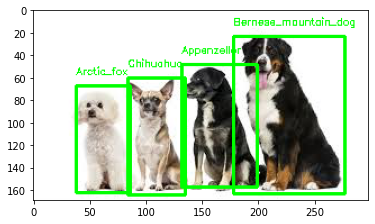

In [78]:
plt.imshow(img)
plt.show()

### 회고: 강아지 라벨링을 하는데 이것도 정확도가 낮은 것도 있었다. 강아지만 정확히 데이터로 가진 
### stanford 강자이 데이터셋을 사용해서 더 정확도가 높은 모델을 만들고 싶다.